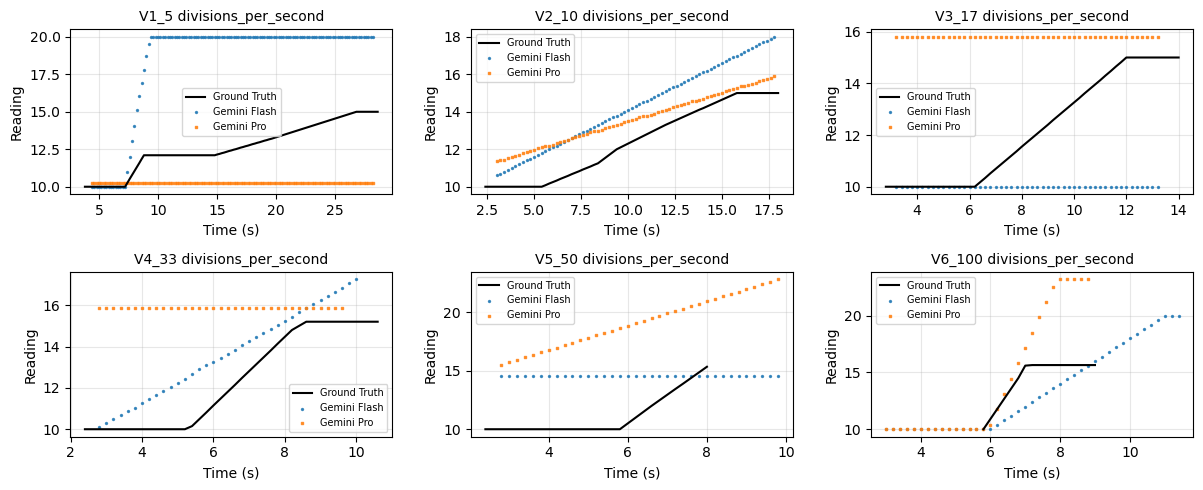

Saved: Analysed\Temporal_Profiles_Depth_6tests.png


In [2]:
"""
Plot temporal profiles for each video: GT vs two Gemini VLM estimates.
Circular Dial gauges: 6 tests. GT from Dataset/1_label, model results from Results/.
"""
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths for Circular Dial gauges (6 tests)
GT_DIR = "Dataset/2_label"
RESULTS_DIRS = [
    ("Results/2.- Analog Depth Gaugegemini-3-flash-preview", "Gemini Flash", "o"),
    ("Results/2.- Analog Depth Gaugegemini-3-pro-preview", "Gemini Pro", "s"),
]
plot_filename = "Temporal_Profiles_Depth_6tests.png"


OUTPUT_DIR = "Figures"
CAPTION = (
    "Temporal profiles for Circular Dial gauges (6 tests). "
    "The solid line represents the encoder-verified ground truth, "
    "while markers indicate VLM predictions."
)


def extract_json_from_text(text):
    try:
        clean_text = re.sub(r"```json|```", "", str(text).strip())
        return json.loads(clean_text)
    except Exception as e:
        print(f"JSON parsing error: {e}")
        return None


def load_gt(gt_path):
    """Load ground truth: timestamp_ms -> time_s, encoder_verified_reading -> value."""
    df = pd.read_excel(gt_path, sheet_name="Ground_Truth")
    df.columns = [str(c).strip().lower() for c in df.columns]
    df = df.sort_values("timestamp_ms")
    t_s = df["timestamp_ms"].values / 1000.0
    val = df["encoder_verified_reading"].values
    return t_s, val


def load_vlm_results(results_dir, seq_id):
    """Load VLM predictions from Raw_Results xlsx: ts_ms -> time_s, reading -> value."""
    path = os.path.join(results_dir, f"{seq_id}_Raw_Results.xlsx")
    if not os.path.exists(path):
        return None, None
    raw_df = pd.read_excel(path)
    raw_response = raw_df.iloc[0]["raw_model_response"]
    vlm_list = extract_json_from_text(raw_response)
    if not vlm_list:
        return None, None
    df = pd.DataFrame(vlm_list)
    df.columns = [str(c).strip().lower() for c in df.columns]
    if "ts_ms" not in df.columns or "reading" not in df.columns:
        print('error code 4871')
        return None, None
    df = df.sort_values("ts_ms")
    t_s = df["ts_ms"].values / 1000.0
    val = df["reading"].values.astype(float)
    return t_s, val


def get_sequence_ids():
    """Find common sequence IDs: have GT and at least one VLM result."""
    if not os.path.exists(GT_DIR):
        print('error code 1235')
        return []
    gt_files = [f for f in os.listdir(GT_DIR) if f.endswith(".xlsx")]
    seq_ids = []
    for f in gt_files:
        seq_id = f.replace(".xlsx", "")
        gt_path = os.path.join(GT_DIR, f)
        if not os.path.isfile(gt_path):
            print('error code 6632')
            continue
        has_any_vlm = any(
            os.path.isfile(os.path.join(rdir, f"{seq_id}_Raw_Results.xlsx"))
            for rdir, _, _ in RESULTS_DIRS
        )
        if has_any_vlm:
            seq_ids.append(seq_id)
    return sorted(seq_ids)


def plot_temporal_profiles():
    seq_ids = get_sequence_ids()
    if not seq_ids:
        print("No sequences found. Check GT_DIR and RESULTS_DIRS paths.")
        return

    n = len(seq_ids)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2.5 * nrows), sharex=False, sharey=False)
    if n == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, seq_id in enumerate(seq_ids):
        ax = axes[idx]
        gt_path = os.path.join(GT_DIR, f"{seq_id}.xlsx")
        t_gt, v_gt = load_gt(gt_path)
        ax.plot(t_gt, v_gt, "-", color="black", linewidth=1.5, label="Ground Truth", zorder=3)

        for res_dir, label, marker in RESULTS_DIRS:
            t_vlm, v_vlm = load_vlm_results(res_dir, seq_id)
            if t_vlm is not None and len(t_vlm) > 0:
                ax.scatter(t_vlm, v_vlm, marker=marker, s=2, alpha=0.8, label=label, zorder=2)

        ax.set_title(seq_id, fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Reading")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best", fontsize=7)

    for j in range(len(seq_ids), len(axes)):
        axes[j].set_visible(False)

#     fig.suptitle(CAPTION, fontsize=11, y=1.02)
    plt.tight_layout()
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    out_path = os.path.join(OUTPUT_DIR, plot_filename)
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
#     plt.close()
    print(f"Saved: {out_path}")


if __name__ == "__main__":
    plot_temporal_profiles()
